# Applying BERT Multilingual Classifier to Predict Account Suspension 

Phase 2

Guidance from: https://github.com/kacossio/TeamPython/blob/master/Bert%20Multilingual%20Embedding.ipynb

## 1. Load Packages

In [159]:
########## Load Packages
import warnings
warnings.simplefilter("ignore")

import importlib
import pandas as pd
import numpy as np
import re
from io import StringIO
import itertools
import os 
import time
import datetime

from io import StringIO # python3; python2: BytesIO 
import boto3

import emoji
import random 
import math

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import math

from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

## 2. Set parameters

In [4]:
# Set Parameters 
########## Set Parameters

# Indicate how many rows to skip before columns
# Note: Python uses zero-based indexing, so skiprow=0 begins at the first row of file,
# while skiprow=1 begins at the second row.
skiprow=0

# Indicate name of column that contains text data for analysis
text_column = "text"

import_bucket = "data/s3_data/full_clean_no_retweets/"

embedding_bucket = "data/s3_data/embeddings/final_embeddings_textclass/"

results_bucket = 'data/s3_data/' # already created on S3

## 3. Load in Data

### Load in data from S3 - Original Data

In [5]:
#### Load in data from S3

# Import Train and Measure Balance
# Import Flattened Data
df_train = pd.read_csv(import_bucket + "df_train_full_cleaned_pe.csv", error_bad_lines=False, encoding='utf-8')

df_train['suspended'] = pd.to_numeric(df_train['suspended'], errors='coerce')
df_train = df_train[df_train['suspended'].notna()]

# Import Test and Measure Balance

df_test = pd.read_csv(import_bucket + "df_test_full_cleaned_pe.csv", error_bad_lines=False, encoding='utf-8')

df_test['suspended'] = pd.to_numeric(df_test['suspended'], errors='coerce')
df_test = df_test[df_test['suspended'].notna()]

# Import Validation and Measure Balance
# Import Flattened Data
df_valid = pd.read_csv(import_bucket + "df_valid_full_cleaned_pe.csv", error_bad_lines=False, encoding='utf-8')

df_valid['suspended'] = pd.to_numeric(df_valid['suspended'], errors='coerce')
df_valid = df_valid[df_valid['suspended'].notna()]

In [6]:
df_train = df_train.drop_duplicates(subset=['id'])
df_valid = df_valid.drop_duplicates(subset=['id'])
df_test = df_test.drop_duplicates(subset=['id'])

### Import Full Dataframes with Embeddings 

Multilingual

In [7]:
bert_embeddings_df_train = pd.read_csv(embedding_bucket + "nort_multilingual/results/ml_training_embeddings_df_full.csv", error_bad_lines=False, encoding='utf-8')
bert_embeddings_df_test = pd.read_csv(embedding_bucket + "nort_multilingual/results/ml_test_embeddings_df_full.csv", error_bad_lines=False, encoding='utf-8')
bert_embeddings_df_valid = pd.read_csv(embedding_bucket + "nort_multilingual/results/ml_valid_embeddings_df_full.csv", error_bad_lines=False, encoding='utf-8')

In [8]:
bert_embeddings_df_train['id'] = bert_embeddings_df_train['id'].apply(lambda x: x.replace("'", ''))
bert_embeddings_df_train['id'] = bert_embeddings_df_train['id'].astype('float')
bert_embeddings_df_valid['id'] = bert_embeddings_df_valid['id'].apply(lambda x: x.replace("'", ''))
bert_embeddings_df_valid['id'] = bert_embeddings_df_valid['id'].astype('float')
bert_embeddings_df_test['id'] = bert_embeddings_df_test['id'].apply(lambda x: x.replace("'", ''))
bert_embeddings_df_test['id'] = bert_embeddings_df_test['id'].astype('float')

Labse

In [9]:
bert_embeddings_df_train_labse = pd.read_csv(embedding_bucket + "nort_labse/results/labse_train_embeddings_df.csv", error_bad_lines=False, encoding='utf-8')
bert_embeddings_df_test_labse = pd.read_csv(embedding_bucket + "nort_labse/results/labse_test_embeddings_df_full.csv", error_bad_lines=False, encoding='utf-8')
bert_embeddings_df_valid_labse = pd.read_csv(embedding_bucket + "nort_labse/results/labse_valid_embeddings_df.csv", error_bad_lines=False, encoding='utf-8')

In [10]:
bert_embeddings_df_train_labse['id'] = bert_embeddings_df_train_labse['id'].apply(lambda x: x.replace("'", ''))
bert_embeddings_df_train_labse['id'] = bert_embeddings_df_train_labse['id'].astype('float')
bert_embeddings_df_valid_labse['id'] = bert_embeddings_df_valid_labse['id'].apply(lambda x: x.replace("'", ''))
bert_embeddings_df_valid_labse['id'] = bert_embeddings_df_valid_labse['id'].astype('float')
bert_embeddings_df_test_labse['id'] = bert_embeddings_df_test_labse['id'].apply(lambda x: x.replace("'", ''))
bert_embeddings_df_test_labse['id'] = bert_embeddings_df_test_labse['id'].astype('float')

### Check Lengths 

In [11]:
print("full train:", len(df_train), "unique ids train:", len(df_train['id'].unique()), 
      "full valid:", len(df_valid), "unique ids valid:", len(df_valid['id'].unique()), 
      "full test:", len(df_test), "unique ids test:", len(df_test['id'].unique()))

full train: 81286 unique ids train: 81286 full valid: 27835 unique ids valid: 27835 full test: 20518 unique ids test: 20518


In [12]:
print("full train:", len(bert_embeddings_df_train), "unique ids train:", len(bert_embeddings_df_train['id'].unique()), 
      "full valid:", len(bert_embeddings_df_valid), "unique ids valid:", len(bert_embeddings_df_valid['id'].unique()), 
      "full test:", len(bert_embeddings_df_test), "unique ids test:", len(bert_embeddings_df_test['id'].unique()))

full train: 81286 unique ids train: 81286 full valid: 27835 unique ids valid: 27835 full test: 20518 unique ids test: 20518


In [13]:
print("full train:", len(bert_embeddings_df_train_labse), "unique ids train:", len(bert_embeddings_df_train_labse['id'].unique()), 
      "full valid:", len(bert_embeddings_df_valid_labse), "unique ids valid:", len(bert_embeddings_df_valid_labse['id'].unique()), 
      "full test:", len(bert_embeddings_df_test_labse), "unique ids test:", len(bert_embeddings_df_test_labse['id'].unique()))

full train: 81286 unique ids train: 81286 full valid: 27835 unique ids valid: 27835 full test: 20518 unique ids test: 20518


## 5. Base Models: Fully Connected Models (No Fine-Tuning)

In [14]:
import pandas as pd
import re
import numpy as np
from sklearn import preprocessing
import pickle
import pandas as pd
import pickle
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow import keras
import random as rn
from keras.models import Model,save_model, load_model, Sequential
from keras.layers import Flatten,AveragePooling1D,Dropout,Dense,Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
import keras.backend as K
import IPython
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import preprocessing
from keras.utils import to_categorical
import pydot
import graphviz
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import kerastuner as kt
from kerastuner import HyperModel
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Using TensorFlow backend.


Get rid of perfect predictor vars 

In [15]:
bert_embeddings_df_train_fm = bert_embeddings_df_train.drop(['id', "user.id", "user.created_at", "user.has_extended_profile_True", 
                                                             "user.has_extended_profile_False", "user.protected_False", 
                                                             "user.verified_False", "user.geo_enabled_False",
                                                             "user.geo_enabled_True", "user.default_profile_True"], axis=1)
bert_embeddings_df_valid_fm = bert_embeddings_df_valid.drop(['id', "user.id", "user.created_at", "user.has_extended_profile_True", 
                                                             "user.has_extended_profile_False", "user.protected_False", 
                                                             "user.verified_False", "user.geo_enabled_False",
                                                             "user.geo_enabled_True", "user.default_profile_True"], axis=1)
bert_embeddings_df_test_fm = bert_embeddings_df_test.drop(['id', "user.id", "user.created_at", "user.has_extended_profile_True", 
                                                           "user.has_extended_profile_False", "user.protected_False", 
                                                           "user.verified_False", "user.geo_enabled_False",
                                                           "user.geo_enabled_True", "user.default_profile_True"], axis=1)

In [16]:
bert_embeddings_df_train_fm_labse = bert_embeddings_df_train_labse.drop(['id', "user.id", "user.created_at", "user.has_extended_profile_True", 
                                                             "user.has_extended_profile_False", "user.protected_False", 
                                                             "user.verified_False", "user.geo_enabled_False",
                                                             "user.geo_enabled_True", "user.default_profile_True"], axis=1)
bert_embeddings_df_valid_fm_labse = bert_embeddings_df_valid_labse.drop(['id', "user.id", "user.created_at", "user.has_extended_profile_True", 
                                                             "user.has_extended_profile_False", "user.protected_False", 
                                                             "user.verified_False", "user.geo_enabled_False",
                                                             "user.geo_enabled_True", "user.default_profile_True"], axis=1)
bert_embeddings_df_test_fm_labse = bert_embeddings_df_test_labse.drop(['id', "user.id", "user.created_at", "user.has_extended_profile_True", 
                                                           "user.has_extended_profile_False", "user.protected_False", 
                                                           "user.verified_False", "user.geo_enabled_False",
                                                           "user.geo_enabled_True", "user.default_profile_True"], axis=1)

### Prep Data to Convert to Tensor

In [17]:
pd.set_option('display.max_columns', None)
bert_embeddings_df_train.head()

,id,created_at,retweet_count,favorite_count,quoted_status_id,user.id,user.created_at,user.favourites_count,user.followers_count,user.friends_count,user.listed_count,user.statuses_count,quoted_status.user.followers_count,quoted_status.user.friends_count,retweeted_status.user.followers_count,retweeted_status.user.friends_count,user_age,tweets_per_day,since_last_tweet_mins,since_last_tweet_mins_min,since_last_tweet_mins_max,since_last_tweet_mins_mean,avg_tweets_per_hr,avg_tweets_per_day,no_hashtags,no_mentions,no_urls,tw_len,followers_per_followees,containsURL,user.urls_per_tweet,no_hashtags_per_tweet,no_mentions_per_tweet,no_urls_per_tweet,user.followers_countdailychange,user.friends_countdailychange,user.friend_rate,user.followers_rate,user.has_url,user.has_location,user.screen_name.digit_length,user.screen_name.length,is_reply,suspended,source_ Round Year Fun!,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ 「モンストからツイート」,source_Affinitweet.com,source_BIGO LIVE,source_Blog2Social APP,source_CallApp,source_Etsy,source_Instagram,source_Joinfsocial,source_Mobile Web (M2),source_Nintendo Switch Share,source_Paper.li,source_Peing,source_SocialPilot.co,source_TeamSight Publisher,source_TweetDeck,source_Twibbon,source_Twitter Web App,source_Twitter Web Client,source_Twitter for Android,source_Twitter for Mac,source_Twitter for iPad,source_Twitter for iPhone,source_WShare,source_WordPress.com,source_漫威超級戰爭（MARVEL Super War）,lang_False,lang_am,lang_ar,lang_bg,lang_bn,lang_bo,lang_ca,lang_ckb,lang_cs,lang_cy,lang_da,lang_de,lang_el,lang_en,lang_es,lang_et,lang_eu,lang_fa,lang_fi,lang_fr,lang_gu,lang_hi,lang_ht,lang_hu,lang_in,lang_is,lang_it,lang_ja,lang_km,lang_ko,lang_lt,lang_lv,lang_mr,lang_my,lang_ne,lang_nl,lang_no,lang_pl,lang_ps,lang_pt,lang_ro,lang_ru,lang_sd,lang_si,lang_sl,lang_sr,lang_sv,lang_th,lang_tl,lang_tr,lang_uk,lang_und,lang_ur,lang_vi,lang_zh,place.country_Finland,place.country_Hong Kong,place.country_India,place.country_Indonesia,place.country_Italy,place.country_Mongolia,place.country_Pakistan,place.country_People's Republic of China,place.country_Portugal,place.country_Republic of Korea,place.country_Russia,place.country_Singapore,place.country_Sri Lanka,place.country_United Arab Emirates,place.country_United States,user.geo_enabled_False,user.geo_enabled_True,user.verified_False,user.has_extended_profile_False,user.has_extended_profile_True,user.protected_False,user.verified_False.1,user.default_profile_True,is_quote_status_False,is_quote_status_True,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387

In [18]:
#combined_features_train = bert_embeddings_df_train.drop(['suspended'], axis=1)
acct_features_train = bert_embeddings_df_train_fm.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_train_fm.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_train = bert_embeddings_df_train_fm.iloc[:, bert_embeddings_df_train_fm.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_train = bert_embeddings_df_train_fm['suspended']

#bert_embeddings_df_train.drop(['suspended'], axis=1).columns.get_loc(0)

#gets country label number
num_of_labels=labels_train.nunique()
num_of_labels

2

In [19]:
labels_train.unique()

array([0, 1])

#### Feature Selection

#### Option 1: Use Random Forest Feature Selection for Account Features 

I specify the random forest instance, indicating the number of trees. Then I use selectFromModel object from sklearn to automatically select the features.

To note, this is much faster than LASSO. 

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

Double check to ensure no missingness ahead of random forest feature selection 

In [21]:
pd.set_option('display.max_rows', None)
acct_features_train.isna().sum()

created_at                                     0
retweet_count                               1143
favorite_count                              1143
quoted_status_id                               0
user.favourites_count                          0
user.followers_count                           0
user.friends_count                             0
user.listed_count                              0
user.statuses_count                            0
quoted_status.user.followers_count             0
quoted_status.user.friends_count               0
retweeted_status.user.followers_count          0
retweeted_status.user.friends_count            0
user_age                                       0
tweets_per_day                                 0
since_last_tweet_mins                       1515
since_last_tweet_mins_min                      6
since_last_tweet_mins_max                      6
since_last_tweet_mins_mean                     6
avg_tweets_per_hr                              0
avg_tweets_per_day  

In [22]:
start_time = time.time()

acct_features_train['since_last_tweet_mins'] = pd.to_numeric(acct_features_train['since_last_tweet_mins'], errors='coerce')
acct_features_train['user.followers_countdailychange'] = pd.to_numeric(acct_features_train['user.followers_countdailychange'], errors='coerce')
acct_features_train['user.friends_countdailychange'] = pd.to_numeric(acct_features_train['user.friends_countdailychange'], errors='coerce')

acct_features_train = acct_features_train.replace([np.inf, -np.inf], np.nan)

acct_features_train = acct_features_train.fillna(0)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.11982607841491699 seconds ---


In [23]:
#generate random seed
def random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   tf.random.set_seed(seed)
   np.random.seed(seed)
   rn.seed(seed)

random_seeds(1234)

In [81]:
feat_labels = acct_features_train.columns

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(acct_features_train, labels_train)
importances = forest.feature_importances_ # probably even simpler than the code I had

indices = np.argsort(importances)[::-1]

In [82]:
for f in range(acct_features_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) user.friends_countdailychange  0.074196
 2) avg_tweets_per_day             0.074101
 3) since_last_tweet_mins_max      0.073654
 4) avg_tweets_per_hr              0.056858
 5) since_last_tweet_mins_mean     0.056590
 6) user.friends_count             0.056298
 7) user.statuses_count            0.050620
 8) no_urls_per_tweet              0.049279
 9) user.followers_countdailychange 0.048262
10) user.urls_per_tweet            0.046772
11) no_mentions_per_tweet          0.040395
12) followers_per_followees        0.039741
13) user.favourites_count          0.039145
14) user.followers_count           0.032535
15) no_hashtags_per_tweet          0.031322
16) tweets_per_day                 0.025748
17) user.screen_name.length        0.024581
18) user.followers_rate            0.021395
19) user.friend_rate               0.020276
20) user.screen_name.digit_length  0.020068
21) user.has_location              0.020028
22) created_at                     0.018173
23) user_age                   

To see which features are important we can use get_support method on the fitted model. It will return an array of boolean values. True for the features whose importance is greater than the mean importance and False for the rest.

In [83]:
sel = SelectFromModel(forest, prefit=True)
selected_feat= acct_features_train.columns[(sel.get_support())]
len(selected_feat)

26

In [84]:
selected_feat

Index(['created_at', 'user.favourites_count', 'user.followers_count',
       'user.friends_count', 'user.listed_count', 'user.statuses_count',
       'user_age', 'tweets_per_day', 'since_last_tweet_mins_max',
       'since_last_tweet_mins_mean', 'avg_tweets_per_hr', 'avg_tweets_per_day',
       'followers_per_followees', 'user.urls_per_tweet',
       'no_hashtags_per_tweet', 'no_mentions_per_tweet', 'no_urls_per_tweet',
       'user.followers_countdailychange', 'user.friends_countdailychange',
       'user.friend_rate', 'user.followers_rate', 'user.has_location',
       'user.screen_name.digit_length', 'user.screen_name.length',
       'source_Twitter Web App', 'source_Twitter for Android'],
      dtype='object')

In [85]:
scaler = StandardScaler()

acct_features_train = acct_features_train[selected_feat]

# Scale account features 
acct_features_train[acct_features_train.columns] = scaler.fit_transform(acct_features_train[acct_features_train.columns])

combined_features_train = pd.concat([acct_features_train, text_feature_train], axis=1)

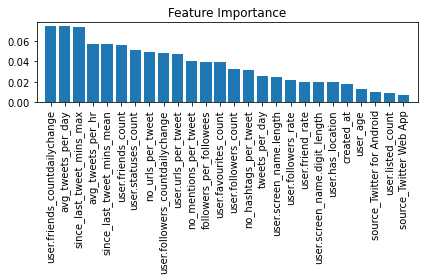

In [96]:
plt.title('Feature Importance')
plt.bar(range(acct_features_train.shape[1]), 
        importances[indices][0:len(selected_feat)],
        align='center')

plt.xticks(range(acct_features_train.shape[1]), 
           feat_labels[indices][0:len(selected_feat)], rotation=90)
plt.xlim([-1, acct_features_train.shape[1]])
plt.tight_layout()
plt.savefig(results_bucket + 'nort_feature_importance.png', dpi=300)
plt.show()

Subset the account features dataset to include only important vars as determined by RF feature selection

#### Resume after feature selection

Valid

In [98]:
#combined_features_valid = bert_embeddings_df_valid.drop(['suspended'], axis=1)
acct_features_valid = bert_embeddings_df_valid_fm.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_valid_fm.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_valid = bert_embeddings_df_valid_fm.iloc[:, bert_embeddings_df_valid_fm.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_valid = bert_embeddings_df_valid_fm['suspended']

#gets country label number
num_of_labels_valid=labels_valid.nunique()
num_of_labels_valid

2

In [99]:
acct_features_valid = acct_features_valid[selected_feat]

### Interpolate Validation and Test to Match up with Train

In [100]:
#pd.set_option('display.max_rows', None)
acct_features_valid.isna().sum()

created_at                           0
user.favourites_count                0
user.followers_count                 0
user.friends_count                   0
user.listed_count                    0
user.statuses_count                  0
user_age                             0
tweets_per_day                       0
since_last_tweet_mins_max            1
since_last_tweet_mins_mean           1
avg_tweets_per_hr                    0
avg_tweets_per_day                   0
followers_per_followees              5
user.urls_per_tweet                  0
no_hashtags_per_tweet                0
no_mentions_per_tweet                0
no_urls_per_tweet                    0
user.followers_countdailychange    278
user.friends_countdailychange      278
user.friend_rate                     4
user.followers_rate                410
user.has_location                    0
user.screen_name.digit_length        0
user.screen_name.length              0
source_Twitter Web App               0
source_Twitter for Androi

In [101]:
start_time = time.time()

acct_features_valid['user.followers_countdailychange'] = pd.to_numeric(acct_features_valid['user.followers_countdailychange'], errors='coerce')
acct_features_valid['user.friends_countdailychange'] = pd.to_numeric(acct_features_valid['user.friends_countdailychange'], errors='coerce')

acct_features_valid = acct_features_valid.replace([np.inf, -np.inf], np.nan)

acct_features_valid = acct_features_valid.fillna(0)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.013069629669189453 seconds ---


In [102]:
len(acct_features_valid.columns)

26

Scale valid features

In [103]:
# Scale account features 
acct_features_valid[acct_features_valid.columns] = scaler.fit_transform(acct_features_valid[acct_features_valid.columns])

In [104]:
combined_features_valid = pd.concat([acct_features_valid, text_feature_valid], axis=1)

Test

In [105]:
acct_features_test = bert_embeddings_df_test_fm.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_test_fm.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_test = bert_embeddings_df_test_fm.iloc[:, bert_embeddings_df_test_fm.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_test = bert_embeddings_df_test_fm['suspended']

#gets country label number
num_of_labels_test=labels_test.nunique()
num_of_labels_test

2

In [106]:
acct_features_test = acct_features_test[selected_feat]

In [107]:
#pd.set_option('display.max_rows', None)
acct_features_test.isna().sum()

created_at                           0
user.favourites_count                0
user.followers_count                 0
user.friends_count                   0
user.listed_count                    0
user.statuses_count                  0
user_age                             0
tweets_per_day                       0
since_last_tweet_mins_max            2
since_last_tweet_mins_mean           2
avg_tweets_per_hr                    0
avg_tweets_per_day                   0
followers_per_followees              5
user.urls_per_tweet                  0
no_hashtags_per_tweet                0
no_mentions_per_tweet                0
no_urls_per_tweet                    0
user.followers_countdailychange    259
user.friends_countdailychange      259
user.friend_rate                     2
user.followers_rate                359
user.has_location                    0
user.screen_name.digit_length        0
user.screen_name.length              0
source_Twitter Web App               0
source_Twitter for Androi

In [108]:
start_time = time.time()

acct_features_test['user.followers_countdailychange'] = pd.to_numeric(acct_features_test['user.followers_countdailychange'], errors='coerce')
acct_features_test['user.friends_countdailychange'] = pd.to_numeric(acct_features_test['user.friends_countdailychange'], errors='coerce')

acct_features_test = acct_features_test.replace([np.inf, -np.inf], np.nan)

acct_features_test = acct_features_test.fillna(0)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.010803937911987305 seconds ---


In [109]:
len(acct_features_test.columns)

26

In [110]:
# Scale account features 
acct_features_test[acct_features_test.columns] = scaler.fit_transform(acct_features_test[acct_features_test.columns])

In [111]:
combined_features_test = pd.concat([acct_features_test, text_feature_test], axis=1)

#### Calculate class weights to address class imbalance problem. 

In [112]:
mapping = {0:0, 1:1}

def data_prep(dataset):
    y = []
    for i in range(0,len(dataset)):
        y_val = np.zeros(2)
        y_val[mapping[dataset[i]]] = 1
        y.append(y_val)
    return np.array(y)

In [113]:
labels_train_fw = data_prep(labels_train)
len(labels_train_fw)

81286

In [114]:
class_counts = [0, 0]
for el in labels_train_fw :
    class_counts[np.argmax(el)]+=1
class_weights = {idx:sum(class_counts)/el for idx, el in enumerate(class_counts)}

#### Label Encoding

In [115]:
#Label encoding (Have not had work yet, but may on full data)
def label_encoding(labels):
    LE = LabelEncoder()
    fit=LE.fit(labels)
    labels =fit.transform(labels)
    labels = to_categorical(labels)
    return labels, fit

In [116]:
#Test label_encoding
labels_train, fit_train=label_encoding(labels_train)
labels_valid, fit_valid=label_encoding(labels_valid)
labels_test, fit_test=label_encoding(labels_test)

In [117]:
#generate random seed
def random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   tf.random.set_seed(seed)
   np.random.seed(seed)
   rn.seed(seed)

#set seed
random_seeds(1234)

#### LabSe Processing

In [118]:
### Prep Data to Convert to Tensor

In [119]:
pd.set_option('display.max_columns', None)
bert_embeddings_df_train_labse.head()

,id,created_at,retweet_count,favorite_count,quoted_status_id,user.id,user.created_at,user.favourites_count,user.followers_count,user.friends_count,user.listed_count,user.statuses_count,quoted_status.user.followers_count,quoted_status.user.friends_count,retweeted_status.user.followers_count,retweeted_status.user.friends_count,user_age,tweets_per_day,since_last_tweet_mins,since_last_tweet_mins_min,since_last_tweet_mins_max,since_last_tweet_mins_mean,avg_tweets_per_hr,avg_tweets_per_day,no_hashtags,no_mentions,no_urls,tw_len,followers_per_followees,containsURL,user.urls_per_tweet,no_hashtags_per_tweet,no_mentions_per_tweet,no_urls_per_tweet,user.followers_countdailychange,user.friends_countdailychange,user.friend_rate,user.followers_rate,user.has_url,user.has_location,user.screen_name.digit_length,user.screen_name.length,is_reply,suspended,source_ Round Year Fun!,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ 「モンストからツイート」,source_Affinitweet.com,source_BIGO LIVE,source_Blog2Social APP,source_CallApp,source_Etsy,source_Instagram,source_Joinfsocial,source_Mobile Web (M2),source_Nintendo Switch Share,source_Paper.li,source_Peing,source_SocialPilot.co,source_TeamSight Publisher,source_TweetDeck,source_Twibbon,source_Twitter Web App,source_Twitter Web Client,source_Twitter for Android,source_Twitter for Mac,source_Twitter for iPad,source_Twitter for iPhone,source_WShare,source_WordPress.com,source_漫威超級戰爭（MARVEL Super War）,lang_False,lang_am,lang_ar,lang_bg,lang_bn,lang_bo,lang_ca,lang_ckb,lang_cs,lang_cy,lang_da,lang_de,lang_el,lang_en,lang_es,lang_et,lang_eu,lang_fa,lang_fi,lang_fr,lang_gu,lang_hi,lang_ht,lang_hu,lang_in,lang_is,lang_it,lang_ja,lang_km,lang_ko,lang_lt,lang_lv,lang_mr,lang_my,lang_ne,lang_nl,lang_no,lang_pl,lang_ps,lang_pt,lang_ro,lang_ru,lang_sd,lang_si,lang_sl,lang_sr,lang_sv,lang_th,lang_tl,lang_tr,lang_uk,lang_und,lang_ur,lang_vi,lang_zh,place.country_Finland,place.country_Hong Kong,place.country_India,place.country_Indonesia,place.country_Italy,place.country_Mongolia,place.country_Pakistan,place.country_People's Republic of China,place.country_Portugal,place.country_Republic of Korea,place.country_Russia,place.country_Singapore,place.country_Sri Lanka,place.country_United Arab Emirates,place.country_United States,user.geo_enabled_False,user.geo_enabled_True,user.verified_False,user.has_extended_profile_False,user.has_extended_profile_True,user.protected_False,user.verified_False.1,user.default_profile_True,is_quote_status_False,is_quote_status_True,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387

In [120]:
#combined_features_train = bert_embeddings_df_train.drop(['suspended'], axis=1)
acct_features_train_labse = bert_embeddings_df_train_fm_labse.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_train_fm_labse.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_train_labse = bert_embeddings_df_train_fm_labse.iloc[:, bert_embeddings_df_train_fm_labse.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_train_labse = bert_embeddings_df_train_fm_labse['suspended']

In [121]:
acct_features_train_labse = acct_features_train_labse[selected_feat]

In [122]:
acct_features_train_labse.isna().sum()

created_at                           0
user.favourites_count                0
user.followers_count                 0
user.friends_count                   0
user.listed_count                    0
user.statuses_count                  0
user_age                             0
tweets_per_day                       0
since_last_tweet_mins_max            6
since_last_tweet_mins_mean           6
avg_tweets_per_hr                    0
avg_tweets_per_day                   0
followers_per_followees            260
user.urls_per_tweet                  0
no_hashtags_per_tweet                0
no_mentions_per_tweet                0
no_urls_per_tweet                    0
user.followers_countdailychange    807
user.friends_countdailychange      807
user.friend_rate                    52
user.followers_rate                998
user.has_location                    0
user.screen_name.digit_length        0
user.screen_name.length              0
source_Twitter Web App               0
source_Twitter for Androi

In [123]:
start_time = time.time()

acct_features_train_labse['user.followers_countdailychange'] = pd.to_numeric(acct_features_train_labse['user.followers_countdailychange'], errors='coerce')
acct_features_train_labse['user.friends_countdailychange'] = pd.to_numeric(acct_features_train_labse['user.friends_countdailychange'], errors='coerce')

acct_features_train_labse = acct_features_train_labse.replace([np.inf, -np.inf], np.nan)

acct_features_train_labse = acct_features_train_labse.fillna(0)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.03165912628173828 seconds ---


In [124]:
len(acct_features_train_labse.columns)

26

Standardize features

In [125]:
acct_features_train_labse[acct_features_train_labse.columns] = scaler.fit_transform(acct_features_train_labse[acct_features_train_labse.columns])

In [126]:
combined_features_train_labse = pd.concat([acct_features_train_labse, text_feature_train_labse], axis=1)

In [127]:
#combined_features_valid = bert_embeddings_df_valid.drop(['suspended'], axis=1)
acct_features_valid_labse = bert_embeddings_df_valid_fm_labse.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_valid_fm_labse.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_valid_labse = bert_embeddings_df_valid_fm_labse.iloc[:, bert_embeddings_df_valid_fm_labse.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_valid_labse = bert_embeddings_df_valid_fm_labse['suspended']

In [128]:
acct_features_valid_labse = acct_features_valid_labse[selected_feat]

### Interpolate Validation and Test to Match up with Train

In [129]:
acct_features_valid_labse.isna().sum()

created_at                           0
user.favourites_count                0
user.followers_count                 0
user.friends_count                   0
user.listed_count                    0
user.statuses_count                  0
user_age                             0
tweets_per_day                       0
since_last_tweet_mins_max            1
since_last_tweet_mins_mean           1
avg_tweets_per_hr                    0
avg_tweets_per_day                   0
followers_per_followees              5
user.urls_per_tweet                  0
no_hashtags_per_tweet                0
no_mentions_per_tweet                0
no_urls_per_tweet                    0
user.followers_countdailychange    278
user.friends_countdailychange      278
user.friend_rate                     4
user.followers_rate                410
user.has_location                    0
user.screen_name.digit_length        0
user.screen_name.length              0
source_Twitter Web App               0
source_Twitter for Androi

In [130]:
start_time = time.time()

acct_features_valid_labse['user.followers_countdailychange'] = pd.to_numeric(acct_features_valid_labse['user.followers_countdailychange'], errors='coerce')
acct_features_valid_labse['user.friends_countdailychange'] = pd.to_numeric(acct_features_valid_labse['user.friends_countdailychange'], errors='coerce')

acct_features_valid_labse = acct_features_valid_labse.replace([np.inf, -np.inf], np.nan)

acct_features_valid_labse = acct_features_valid_labse.fillna(0)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.013779878616333008 seconds ---


In [131]:
len(acct_features_valid_labse.columns)

26

Standardize Features

In [132]:
acct_features_valid_labse[acct_features_valid_labse.columns] = scaler.fit_transform(acct_features_valid_labse[acct_features_valid_labse.columns])

In [133]:
combined_features_valid_labse = pd.concat([acct_features_valid_labse, text_feature_valid_labse], axis=1)

In [134]:
acct_features_test_labse = bert_embeddings_df_test_fm_labse.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_test_fm_labse.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_test_labse = bert_embeddings_df_test_fm_labse.iloc[:, bert_embeddings_df_test_fm_labse.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_test_labse = bert_embeddings_df_test_fm_labse['suspended']

In [135]:
acct_features_test_labse = acct_features_test_labse[selected_feat]

In [136]:
#pd.set_option('display.max_rows', None)
acct_features_test_labse.isna().sum()

created_at                           0
user.favourites_count                0
user.followers_count                 0
user.friends_count                   0
user.listed_count                    0
user.statuses_count                  0
user_age                             0
tweets_per_day                       0
since_last_tweet_mins_max            2
since_last_tweet_mins_mean           2
avg_tweets_per_hr                    0
avg_tweets_per_day                   0
followers_per_followees              5
user.urls_per_tweet                  0
no_hashtags_per_tweet                0
no_mentions_per_tweet                0
no_urls_per_tweet                    0
user.followers_countdailychange    259
user.friends_countdailychange      259
user.friend_rate                     2
user.followers_rate                359
user.has_location                    0
user.screen_name.digit_length        0
user.screen_name.length              0
source_Twitter Web App               0
source_Twitter for Androi

In [137]:
start_time = time.time()

acct_features_test_labse['user.followers_countdailychange'] = pd.to_numeric(acct_features_test_labse['user.followers_countdailychange'], errors='coerce')
acct_features_test_labse['user.friends_countdailychange'] = pd.to_numeric(acct_features_test_labse['user.friends_countdailychange'], errors='coerce')

acct_features_test_labse = acct_features_test_labse.replace([np.inf, -np.inf], np.nan)

acct_features_test_labse = acct_features_test_labse.fillna(0)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.011429786682128906 seconds ---


In [138]:
len(acct_features_test_labse.columns)

26

Standardize Features

In [139]:
acct_features_test_labse[acct_features_test_labse.columns] = scaler.fit_transform(acct_features_test_labse[acct_features_test_labse.columns])

In [140]:
combined_features_test_labse = pd.concat([acct_features_test_labse, text_feature_test_labse], axis=1)

In [141]:
labels_train_fw_labse = data_prep(labels_train_labse)
len(labels_train_fw_labse)

81286

In [142]:
class_counts = [0, 0]
for el in labels_train_fw_labse :
    class_counts[np.argmax(el)]+=1
class_weights_labse = {idx:sum(class_counts)/el for idx, el in enumerate(class_counts)}

In [143]:
#Test label_encoding
labels_train_labse, fit_train_labse=label_encoding(labels_train_labse)
labels_valid_labse, fit_valid_labse=label_encoding(labels_valid_labse)
labels_test_labse, fit_test_labse=label_encoding(labels_test_labse)

#### Account only model  

In [144]:
#make sure numpy array
train_data_acc = np.array(acct_features_train).astype(np.float32)
valid_data_acc = np.array(acct_features_valid).astype(np.float32)
test_data_acc = np.array(acct_features_test).astype(np.float32)

train_labels = labels_train
valid_labels = labels_valid
test_labels = labels_test

In [145]:
#input shape for account features
input_shape_acc=train_data_acc[0].shape
input_shape_acc

(26,)

In [146]:
#Function for model flow. Does not include any parameter tuning
def model_flow(model_name, num_of_labels, input_shape):
    inputs = keras.Input(shape=(input_shape), name="Combined_inputs")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.BatchNormalization(name="normalization_1")(x)
    x = layers.Dense(32, activation="relu",name="dense_2")(x)
    x = layers.Dense(16, activation=tf.keras.layers.LeakyReLU(alpha=0.2), name="dense_3")(x)
    x = layers.Dropout(0.15)(x) # SHOULD WE CONSIDER INCREASING TOP 0.5?
    outputs = layers.Dense(num_of_labels, activation="softmax",name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    return model

# DO WE NEED DROPOUT AFTER EACH LAYER INSTEAD OF RIGHT AT THE END? 

In [147]:
#model flow and summary
Acc_model = model_flow("Account_Info",num_of_labels, input_shape_acc)
Acc_model.summary()

Model: "Account_Info"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Combined_inputs (InputLayer) [(None, 26)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1728      
_________________________________________________________________
normalization_1 (BatchNormal (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
predictions (Dense)          (None, 2)                

In [148]:
#Compile  model
Acc_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [149]:
#Fitting on training and validation data
print("Fit model on Account Information features training data")
history_acc = Acc_model.fit(train_data_acc, train_labels, epochs=2, batch_size=15,
                   validation_data=(valid_data_acc, valid_labels), class_weight=class_weights)

Fit model on Account Information features training data
Epoch 1/2
5420/5420 [==============================] - 9s 2ms/step - loss: 0.6139 - accuracy: 0.8482 - val_loss: 0.8194 - val_accuracy: 0.7939
Epoch 2/2
5420/5420 [==============================] - 9s 2ms/step - loss: 0.2148 - accuracy: 0.9582 - val_loss: 1.2630 - val_accuracy: 0.7450


In [150]:
# Evaluate the model on the test data
print("Evaluate on Account Information features test data")
Acc_model_results = Acc_model.evaluate(test_data_acc, test_labels, batch_size=10)

Evaluate on Account Information features test data
2052/2052 [==============================] - 2s 772us/step - loss: 1.1321 - accuracy: 0.8061


#### Save Model 

In [151]:
from tensorflow.keras.layers import LeakyReLU
Acc_model.save('data/s3_data/model_output/full_test_interp_Acc_model.h5')  # creates a HDF5 file 'my_model.h5'

#### Load back in model 

In [152]:
from tensorflow.keras.models import load_model

Acc_model = load_model('data/s3_data/model_output/full_test_interp_Acc_model.h5', custom_objects = {'LeakyReLU':LeakyReLU})

#### Make Predictions

For Tweets

In [153]:
# Generate predictions (location probabilities)
def predict_test(model,test_data, test_labels, fit):
    predictions = model.predict(test_data)
    #y_true=np.argmax(test_labels, axis=0) 
    #y_pred=np.argmax(predictions, axis =0)
    #get labels of prediction
    #label_pred=fit.inverse_transform(y_pred)
    #metrics
    report = classification_report(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))
    return report # label_pred

In [154]:
#test predict_test
metrics_report_acc=predict_test(Acc_model,test_data_acc,test_labels, fit_test)

# predicted_susp_tweettext
print(metrics_report_acc)


              precision    recall  f1-score   support

           0       0.90      0.88      0.89     18480
           1       0.12      0.15      0.13      2038

    accuracy                           0.81     20518
   macro avg       0.51      0.51      0.51     20518
weighted avg       0.83      0.81      0.82     20518



In [156]:
predictions = Acc_model.predict(test_data_acc)

In [157]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)  

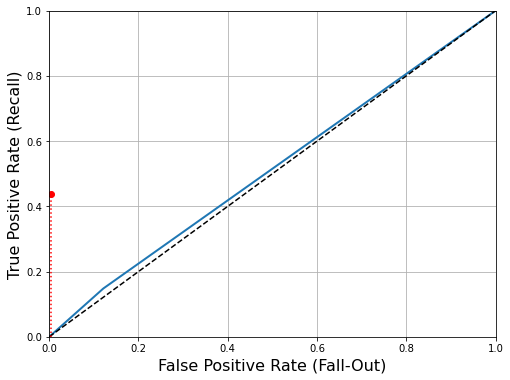

In [160]:
fpr, tpr, thresholds = roc_curve(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [161]:
roc_auc_score(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))

0.5134320741411026

For Accounts

In [162]:
# Generate summed probabilities at the account level 
def predict_account(model, df_mod, df_bert, df_full):
    predictions = model.predict(df_mod)[:,1]
    df = pd.DataFrame(predictions, columns = ['pred'])
    df_2 = pd.merge(df_bert.reset_index()['user.id'], df, left_index=True, right_index=True)
    df_fm = df_full[['user.screen_name','user.id', 'suspended']].drop_duplicates(subset=['user.screen_name','user.id'])
    df_3 = pd.merge(df_fm, df_2, left_on='user.id', right_on='user.id')
    df_4 = df_3[['user.screen_name', 'suspended','pred']].groupby('user.screen_name').agg(['sum', 'mean'])
    df_4.drop(('suspended', 'sum'), axis = 1, inplace = True)
    df_4.columns = df_4.columns = [' '.join(col).strip() for col in df_4.columns.values]
    df_4.reset_index(level=0, inplace=True)
    df_4.columns = ["user.screen_name","suspended_label", "total_pre_prob","mean_pred_prob"]
    df_4['pred_class'] = np.where(df_4['mean_pred_prob'] > 0.25, 1,0) # Use lighter threshold as not all tweets get an account suspended. 
    df_4 = df_4.sort_values(by=['total_pre_prob'], ascending=False)

    return df_4

In [163]:
# Generate summed probabilities at the account level 
def predict_tweet_text(model, df_mod, df_bert, df_full):
    predictions = model.predict(df_mod)[:,1]
    df = pd.DataFrame(predictions, columns = ['pred'])
    df_2 = pd.merge(df_bert.reset_index()['id'], df, left_index=True, right_index=True)
    df_fm = df_full[['id', 'text','user.screen_name','user.id', 'suspended']].drop_duplicates(subset=['user.screen_name','user.id'])
    df_fm['id'] = df_fm['id'].apply(lambda x: x.replace("'", ''))
    df_fm['id'] = df_fm['id'].astype('float')
    df_fm['id'] = df_fm['id'].astype('str')
    df_fm['id'] = df_fm['id'].apply(lambda x: "'" + x + "'")
    df_2['id'] = df_2['id'].astype('str')
    df_2['id'] = df_2['id'].apply(lambda x: "'" + x + "'")
    df_3 = pd.merge(df_fm, df_2, left_on='id', right_on='id')
    df_3.columns = ["id", "text", "user.screen_name", "user.id", "suspended_label", "pred"]
    df_3 = df_3.sort_values(by=['pred'], ascending=False)

    return df_3

In [164]:
test_preds_tweets = predict_tweet_text(Acc_model, test_data_acc, bert_embeddings_df_test, df_test)
test_preds_tweets.head()

,id,text,user.screen_name,user.id,suspended_label,pred
36,'1.292717730802606e+18',Trend\n@DrSikandarCh1 \n@ArshiaAttiq \n@AtikaH...,CHauDHa66204206,1.278479e+18,0,1.0
74,'1.2796344637611622e+18',@AWWk67D3QPyM6Ji 想抱,xixixix78789521,1.278926e+18,0,1.0
450,'1.2864536891341537e+18',@VOAChinese 来了再给你送回去,linfeng25635632,1.285772e+18,0,1.0
424,'1.3024052295104963e+18',@PDChinese 向烈士致敬！,XiaoTan83593037,1.284755e+18,0,1.0
324,'1.2835782717082296e+18',@Thepastwithwind @SpokespersonCHN 美🐕,funnymudypee,1.282937e+18,0,1.0


In [165]:
test_preds_tweets.to_csv(results_bucket + 'account_level_results/full_test_interp/test_tweets_preds_acc.csv', index=False, encoding = "utf_8_sig")

In [166]:
test_account_preds_acc = predict_account(Acc_model, test_data_acc, bert_embeddings_df_test, df_test)

In [167]:
test_account_preds_acc.to_csv(results_bucket + 'account_level_results/full_test_interp/test_account_preds_acc.csv', index=False, encoding = "utf_8_sig")

In [168]:
#report = classification_report(np.array(test_labels), predictions)
report_te_acc = classification_report(np.array(test_account_preds_acc['suspended_label']), np.array(test_account_preds_acc['pred_class']))
print(report_te_acc)

              precision    recall  f1-score   support

           0       0.94      0.58      0.72       460
           1       0.10      0.58      0.17        38

    accuracy                           0.58       498
   macro avg       0.52      0.58      0.45       498
weighted avg       0.88      0.58      0.68       498



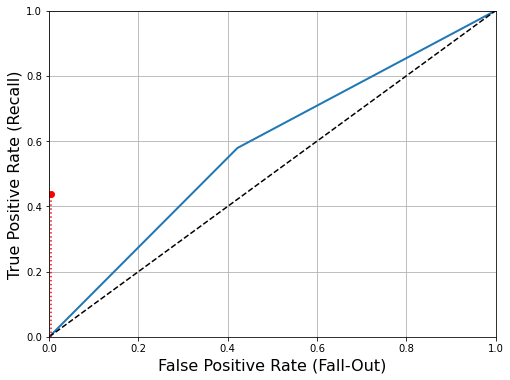

In [169]:
fpr, tpr, thresholds = roc_curve(np.array(test_account_preds_acc['suspended_label']), np.array(test_account_preds_acc['pred_class']))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [170]:
roc_auc_score(np.array(test_account_preds_acc['suspended_label']), np.array(test_account_preds_acc['pred_class']))

0.578604118993135

Tweet Model Results

In [171]:
def accuracy_plot(title_, history_fit):
    plt.plot(history_fit.history['accuracy'])
    plt.plot(history_fit.history['val_accuracy'])
    plt.title(title_)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()
    return plt

# CREATE A LOSS PLOT AS WELL!!!!!

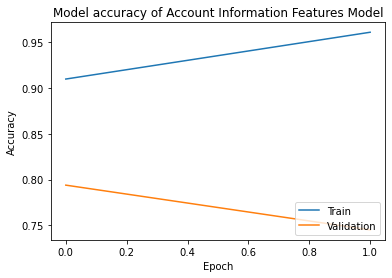

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [1.132050633430481, 0.8061214685440063]


In [172]:
#train vs validation accuracy plot
plot_acc=accuracy_plot('Model accuracy of Account Information Features Model', history_acc)
print(plot_acc)
#test accuracy and loss 
print("test loss, test accuracy:", Acc_model_results)

In [173]:
def loss_plot(title_, history_fit):
    plt.plot(history_fit.history['loss'])
    plt.plot(history_fit.history['val_loss'])
    plt.title(title_)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()
    return plt

# CREATE A LOSS PLOT AS WELL!!!!!

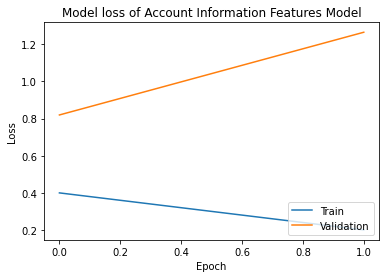

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [1.132050633430481, 0.8061214685440063]


In [174]:
#train vs validation accuracy plot
plot_loss=loss_plot('Model loss of Account Information Features Model', history_acc)
print(plot_loss)
#test accuracy and loss
print("test loss, test accuracy:", Acc_model_results)

#### Combined Model

Multilingual

In [175]:
#make sure numpy array
train_data = np.array(combined_features_train).astype(np.float32)
valid_data = np.array(combined_features_valid).astype(np.float32)
test_data = np.array(combined_features_test).astype(np.float32)

train_labels = labels_train
valid_labels = labels_valid
test_labels = labels_test

In [176]:
#gets shape of the data for the model
input_shape_combined=train_data[0].shape
input_shape_combined

(794,)

In [177]:
train_data[0].shape

(794,)

In [178]:
#set seed
random_seeds(1234)

In [179]:
#test model_flow
Combined_model = model_flow("Combined",num_of_labels, input_shape_combined)

In [180]:
#model summary
Combined_model.summary()


Model: "Combined"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Combined_inputs (InputLayer) [(None, 794)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50880     
_________________________________________________________________
normalization_1 (BatchNormal (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
predictions (Dense)          (None, 2)                 34 

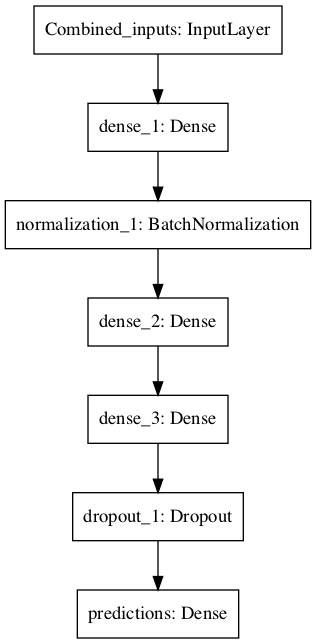

In [181]:
#model diagram
tf.keras.utils.plot_model(Combined_model)

In [182]:
#Compile  model
Combined_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [183]:
#Fitting on training and validation data
print("Fit model on training data")
history_combined = Combined_model.fit(train_data, train_labels, epochs=2, batch_size=15,
                                      validation_data=(valid_data, valid_labels), class_weight = class_weights)

Fit model on training data
Epoch 1/2
5420/5420 [==============================] - 11s 2ms/step - loss: 0.8157 - accuracy: 0.8242 - val_loss: 0.5985 - val_accuracy: 0.7724
Epoch 2/2
5420/5420 [==============================] - 10s 2ms/step - loss: 0.6720 - accuracy: 0.8533 - val_loss: 0.5792 - val_accuracy: 0.7337


In [184]:
# Evaluate the model on the test data
print("Evaluate on test data")
model_results_comb = Combined_model.evaluate(test_data, test_labels, batch_size=10)

Evaluate on test data
2052/2052 [==============================] - 2s 778us/step - loss: 0.6330 - accuracy: 0.7158


#### Save Model 

In [185]:
from tensorflow.keras.layers import LeakyReLU
Combined_model.save('data/s3_data/model_output/full_test_interp_Combined_model.h5')  # creates a HDF5 file 'my_model.h5'

#### Load Model 

In [186]:
from tensorflow.keras.models import load_model

Combined_model = load_model('data/s3_data/model_output/full_test_interp_Combined_model.h5', custom_objects = {'LeakyReLU':LeakyReLU})

#### Predictions

Tweets

In [187]:
#test predict_test
metrics_report_comb=predict_test(Combined_model,test_data,test_labels, fit_test)

# predicted_susp_tweettext
print(metrics_report_comb)

              precision    recall  f1-score   support

           0       0.90      0.77      0.83     18480
           1       0.10      0.25      0.15      2038

    accuracy                           0.72     20518
   macro avg       0.50      0.51      0.49     20518
weighted avg       0.82      0.72      0.76     20518



In [188]:
predictions = Combined_model.predict(test_data)

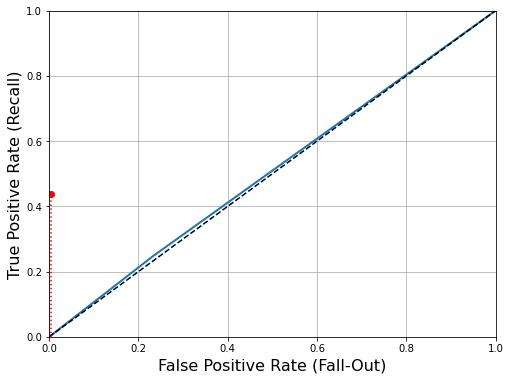

In [189]:
fpr, tpr, thresholds = roc_curve(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [190]:
roc_auc_score(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))

0.5073898153694523

In [191]:
test_preds_tweets = predict_tweet_text(Combined_model, test_data, bert_embeddings_df_test, df_test)
test_preds_tweets.head()

,id,text,user.screen_name,user.id,suspended_label,pred
371,'1.2905278435421676e+18',@jame_deane @zhanglifan 没读过书建议多读书再说话。,Lance15234488,1.283652e+18,0,0.999999
39,'1.2830064584943657e+18',@wifeycurtis @kpsharmaoli soon u'll become an...,ArnabD10,1.278560e+18,0,0.999994
74,'1.2796344637611622e+18',@AWWk67D3QPyM6Ji 想抱,xixixix78789521,1.278926e+18,0,0.999977
433,'1.2877905109421957e+18',@zhang_heqing 关注了,FhSYkK3LVq2bya9,1.285047e+18,1,0.999907
342,'1.3076826514745508e+18',Questions Couples Should Ask (Or Wish They Had...,TwoOld3,1.283207e+18,0,0.999902


In [192]:
test_preds_tweets.to_csv(results_bucket + 'account_level_results/full_test_interp/test_tweets_preds_comb.csv', index=False, encoding = "utf_8_sig")

Accounts

In [193]:
test_account_preds_comb = predict_account(Combined_model, test_data, bert_embeddings_df_test, df_test)

In [194]:
test_account_preds_comb.to_csv(results_bucket + 'account_level_results/full_test_interp/test_account_preds_comb.csv', index=False, encoding = "utf_8_sig")

In [195]:
#report = classification_report(np.array(test_labels), predictions)
report_te_comb = classification_report(np.array(test_account_preds_comb['suspended_label']), np.array(test_account_preds_comb['pred_class']))
print(report_te_comb)

              precision    recall  f1-score   support

           0       0.93      0.30      0.45       460
           1       0.08      0.71      0.14        38

    accuracy                           0.33       498
   macro avg       0.50      0.50      0.29       498
weighted avg       0.86      0.33      0.43       498



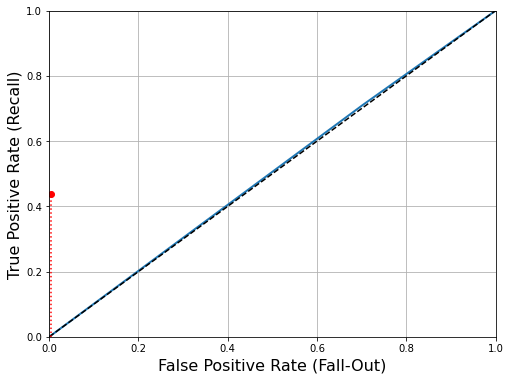

In [197]:
fpr, tpr, thresholds = roc_curve(np.array(test_account_preds_comb['suspended_label']), np.array(test_account_preds_comb['pred_class']))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [198]:
roc_auc_score(np.array(test_account_preds_comb['suspended_label']), np.array(test_account_preds_comb['pred_class']))

0.5041762013729977

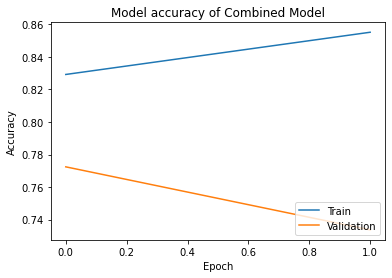

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [0.6330029964447021, 0.7158105373382568]


In [199]:
#train vs validation accuracy plot
plot_combined=accuracy_plot('Model accuracy of Combined Model', history_combined)
print(plot_combined)

print("test loss, test accuracy:", model_results_comb)

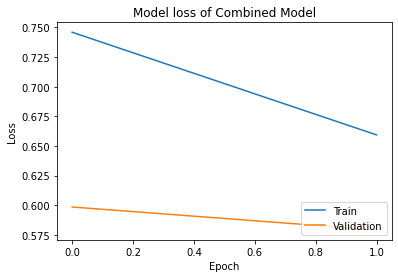

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [0.6330029964447021, 0.7158105373382568]


In [200]:
#train vs validation accuracy plot
plot_loss=loss_plot('Model loss of Combined Model', history_combined)
print(plot_loss)
#test accuracy and loss 
print("test loss, test accuracy:", model_results_comb)

#### Labse

In [201]:
#make sure numpy array
train_data_labse = np.array(combined_features_train_labse).astype(np.float32)
valid_data_labse = np.array(combined_features_valid_labse).astype(np.float32)
test_data_labse = np.array(combined_features_test_labse).astype(np.float32)

train_labels_labse = labels_train_labse
valid_labels_labse = labels_valid_labse
test_labels_labse = labels_test_labse

In [202]:
#gets shape of the data for the model
input_shape_combined_labse=valid_data_labse[0].shape
input_shape_combined_labse

(794,)

In [203]:
#set seed
random_seeds(1234)

In [204]:
#test model_flow
Combined_model_labse = model_flow("Combined",num_of_labels, input_shape_combined_labse)

In [205]:
#model summary
Combined_model_labse.summary()

Model: "Combined"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Combined_inputs (InputLayer) [(None, 794)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50880     
_________________________________________________________________
normalization_1 (BatchNormal (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
predictions (Dense)          (None, 2)                 34 

In [206]:
#Compile  model
Combined_model_labse.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [207]:
#Fitting on training and validation data
print("Fit model on training data")
history_combined_labse = Combined_model_labse.fit(train_data_labse, train_labels_labse, epochs=2, batch_size=15,
                                      validation_data=(valid_data_labse, valid_labels_labse), class_weight = class_weights_labse)

Fit model on training data
Epoch 1/2
5420/5420 [==============================] - 11s 2ms/step - loss: 0.5723 - accuracy: 0.8723 - val_loss: 0.5898 - val_accuracy: 0.7923
Epoch 2/2
5420/5420 [==============================] - 10s 2ms/step - loss: 0.3269 - accuracy: 0.9363 - val_loss: 0.7283 - val_accuracy: 0.7484


In [208]:
# Evaluate the model on the test data
print("Evaluate on test data")
model_results_comb_labse = Combined_model_labse.evaluate(test_data_labse, test_labels_labse, batch_size=10)

Evaluate on test data
2052/2052 [==============================] - 2s 928us/step - loss: 0.8560 - accuracy: 0.8034


In [209]:
from tensorflow.keras.layers import LeakyReLU
Combined_model_labse.save('data/s3_data/model_output/full_test_interp_Combined_model_labse.h5')  # creates a HDF5 file 'my_model.h5'

In [210]:
from tensorflow.keras.models import load_model

Combined_model_labse = load_model('data/s3_data/model_output/full_test_interp_Combined_model_labse.h5', custom_objects = {'LeakyReLU':LeakyReLU})

In [211]:
#test predict_test
metrics_report_comb_labse=predict_test(Combined_model_labse,test_data_labse,test_labels_labse, fit_test_labse)

# predicted_susp_tweettext
print(metrics_report_comb_labse)

              precision    recall  f1-score   support

           0       0.90      0.88      0.89     18480
           1       0.08      0.09      0.09      2038

    accuracy                           0.80     20518
   macro avg       0.49      0.49      0.49     20518
weighted avg       0.82      0.80      0.81     20518



In [212]:
predictions = Combined_model_labse.predict(test_data_labse)

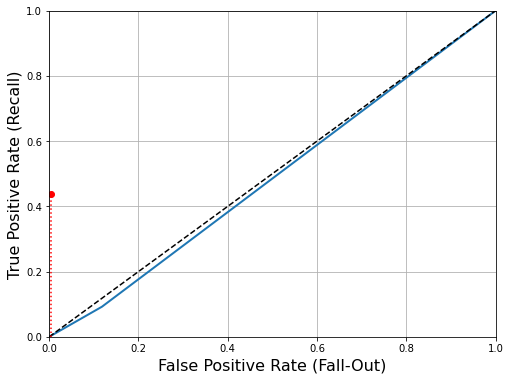

In [213]:
fpr, tpr, thresholds = roc_curve(np.argmax(test_labels_labse, axis=1), np.argmax(predictions, axis=1))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [214]:
roc_auc_score(np.argmax(test_labels_labse, axis=1), np.argmax(predictions, axis=1))

0.4870327415469712

In [215]:
test_preds_tweets = predict_tweet_text(Combined_model_labse, test_data_labse, bert_embeddings_df_test_labse, df_test)
test_preds_tweets.head()

,id,text,user.screen_name,user.id,suspended_label,pred
64,'1.2819469321689334e+18',#foodie #foodpanda #food #FoodBenders #foodwas...,FoodLov39645299,1.278767e+18,0,1.000000
32,'1.2784498271232123e+18',#Kashmir \n#IndianArmy https://t.co/u60Cpmkyvs,AdnanBa23533546,1.278449e+18,0,1.000000
261,'1.3031640429623337e+18',致敬英雄！ https://t.co/cfu0LRgFzj,photo80590124,1.281777e+18,1,1.000000
74,'1.2796344637611622e+18',@AWWk67D3QPyM6Ji 想抱,xixixix78789521,1.278926e+18,0,1.000000
433,'1.2877905109421957e+18',@zhang_heqing 关注了,FhSYkK3LVq2bya9,1.285047e+18,1,0.999998


In [216]:
test_preds_tweets.to_csv(results_bucket + 'account_level_results/full_test_interp/test_tweets_preds_comb_labse.csv', index=False, encoding = "utf_8_sig")

Accounts

Test

In [217]:
test_account_preds_comb_labse = predict_account(Combined_model_labse, test_data_labse, bert_embeddings_df_test_labse, df_test)

In [218]:
test_account_preds_comb_labse.to_csv(results_bucket + 'account_level_results/full_test_interp/test_account_preds_comb_labse.csv', index=False, encoding = "utf_8_sig")

In [219]:
#report = classification_report(np.array(test_labels), predictions)
report_te_comb_labse = classification_report(np.array(test_account_preds_comb_labse['suspended_label']), np.array(test_account_preds_comb_labse['pred_class']))
print(report_te_comb_labse)

              precision    recall  f1-score   support

           0       0.93      0.62      0.74       460
           1       0.08      0.42      0.14        38

    accuracy                           0.61       498
   macro avg       0.51      0.52      0.44       498
weighted avg       0.86      0.61      0.70       498



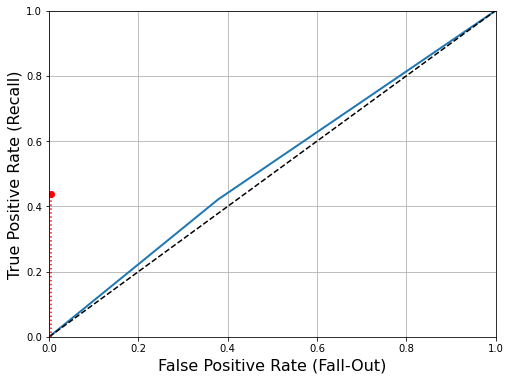

In [220]:
fpr, tpr, thresholds = roc_curve(np.array(test_account_preds_comb_labse['suspended_label']), np.array(test_account_preds_comb_labse['pred_class']))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [223]:
roc_auc_score(np.array(test_account_preds_comb_labse['suspended_label']), np.array(test_account_preds_comb_labse['pred_class']))

0.521395881006865

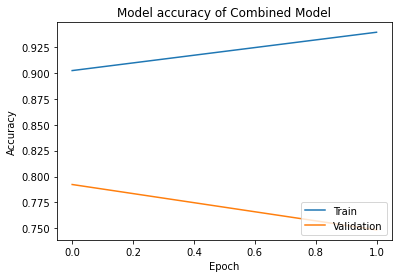

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [0.8560436367988586, 0.8033921718597412]


In [224]:
#train vs validation accuracy plot
plot_combined=accuracy_plot('Model accuracy of Combined Model', history_combined_labse)
print(plot_combined)
#test accuracy
print("test loss, test accuracy:", model_results_comb_labse)

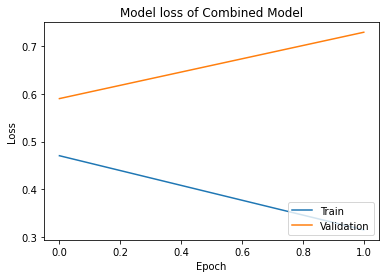

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [0.8560436367988586, 0.8033921718597412]


In [225]:
#train vs validation loss plot
plot_loss=loss_plot('Model loss of Combined Model', history_combined_labse)
print(plot_loss)
#test loss and accuracy
print("test loss, test accuracy:", model_results_comb_labse)

### 3. Fine Tuning Models

In [226]:
#Callbacks
callback1=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=4)

In [227]:
#clears training output
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

#### Account Only Model 

In [228]:
#input shape for account features
input_shape_acc=train_data_acc[0].shape
input_shape_acc

(26,)

In [229]:
def tuner_builder1(hp):
    inputs = keras.Input(shape=input_shape_acc, name="Tuned_Account_Info_Inputs")
    x = layers.Dense(hp.Int('units', 50, 200, step = 20), activation="relu", name="dense_1")(inputs)
    x = layers.BatchNormalization(name="normalization_1")(x)
    x = layers.Dense(hp.Int('units1', 100, 200, step = 50), activation="relu",name="dense_2")(x)
    x = layers.Dense(hp.Int('units2', 20, 100, step = 20), activation=tf.keras.layers.LeakyReLU(alpha=0.2), name="dense_3")(x)
    x = layers.Dropout(hp.Float('dropout',0.0,0.50, step=0.10, default=0.10))(x)
    outputs = layers.Dense(2, activation="softmax",name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name="Tuned_Account_Info_Model")
    #Compile  model
    model.compile(optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=['accuracy'])
    return model

In [230]:
#tuner settings 
Acc_info_tuner = kt.Hyperband(
    tuner_builder1,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory = 'Trial_run_acc_info3',
    project_name = 'Parameters_trials_acc_info929292') # Need to be unique with each run!

In [231]:
#run through tuner
Acc_info_tuner.search(train_data_acc, train_labels,validation_data=(valid_data_acc, valid_labels),callbacks=[callback1,ClearTrainingOutput()])


Trial 90 Complete [00h 00m 25s]
val_accuracy: 0.87070232629776

Best val_accuracy So Far: 0.8860786557197571
Total elapsed time: 00h 28m 46s
INFO:tensorflow:Oracle triggered exit


In [232]:
#gets best parameters
best_hyper_Acc_info = Acc_info_tuner.get_best_hyperparameters(1)[0]
best_hyper_Acc_info
    

In [233]:
print('Best Parameters for 1st Dense layer is', best_hyper_Acc_info.get('units'))

Best Parameters for 1st Dense layer is 190


In [234]:
print('Best Parameters for 2nd Dense layer is', best_hyper_Acc_info.get('units1'))

Best Parameters for 2nd Dense layer is 100


In [235]:
print('Best Parameters for 3rd Dense layer is', best_hyper_Acc_info.get('units2'))

Best Parameters for 3rd Dense layer is 60


In [236]:
print('Best Parameters for Dropout layer is', best_hyper_Acc_info.get('dropout'))

Best Parameters for Dropout layer is 0.4


In [237]:
print('Best learning rate for the ADAM is', best_hyper_Acc_info.get('learning_rate'))

Best learning rate for the ADAM is 0.0004592440621683886


In [238]:
#applies to tuning to model
Acc_info_model_tuned= Acc_info_tuner.hypermodel.build(best_hyper_Acc_info)

In [239]:
#trials using newly tuned model
#Fitting on training and validation data based on selected tuning parameters
print("Fit model on training data with tuned Account Information model")
history_acc_info_tuned = Acc_info_model_tuned.fit(train_data_acc, train_labels, epochs=2, batch_size=15,
                   validation_data=(valid_data_acc, valid_labels), class_weight = class_weights)

Fit model on training data with tuned Account Information model
Epoch 1/2
5420/5420 [==============================] - 11s 2ms/step - loss: 0.5545 - accuracy: 0.8797 - val_loss: 0.6925 - val_accuracy: 0.8425
Epoch 2/2
5420/5420 [==============================] - 10s 2ms/step - loss: 0.1654 - accuracy: 0.9699 - val_loss: 1.0260 - val_accuracy: 0.7490


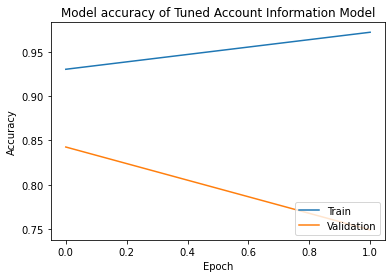

In [240]:
plot_acc_info_tuned=accuracy_plot('Model accuracy of Tuned Account Information Model', history_acc_info_tuned)

In [241]:
# Evaluate the tuned model on the test data 
print("Evaluate tuned Account Information model on test data")
acc_info_tuned_results = Acc_info_model_tuned.evaluate(test_data_acc, test_labels, batch_size=10)

Evaluate tuned Account Information model on test data
2052/2052 [==============================] - 2s 781us/step - loss: 1.3670 - accuracy: 0.8202


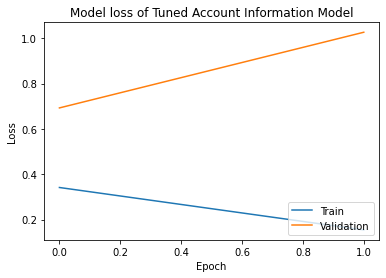

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [1.3670130968093872, 0.8201578855514526]


In [242]:
#train vs validation accuracy plot
plot_loss=loss_plot('Model loss of Tuned Account Information Model', history_acc_info_tuned)
print(plot_loss)
#valid accuracy and loss 
print("test loss, test accuracy:", acc_info_tuned_results)

#### Save Model 

In [243]:
from tensorflow.keras.layers import LeakyReLU
Acc_info_model_tuned.save('data/s3_data/model_output/full_test_interp_Acc_info_model_tuned.h5')  # creates a HDF5 file 'my_model.h5'

#### Load Model 

In [244]:
from tensorflow.keras.models import load_model
Acc_info_model_tuned = load_model('data/s3_data/model_output/full_test_interp_Acc_info_model_tuned.h5', custom_objects = {'LeakyReLU':LeakyReLU})

#### Predict 

Tweets

In [245]:
#test predict_test
metrics_report_acc_tuned=predict_test(Acc_info_model_tuned,test_data_acc,test_labels, fit_test)

# predicted_susp_tweettext
print(metrics_report_acc_tuned)

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     18480
           1       0.10      0.10      0.10      2038

    accuracy                           0.82     20518
   macro avg       0.50      0.50      0.50     20518
weighted avg       0.82      0.82      0.82     20518



In [246]:
predictions = Acc_info_model_tuned.predict(test_data_acc)

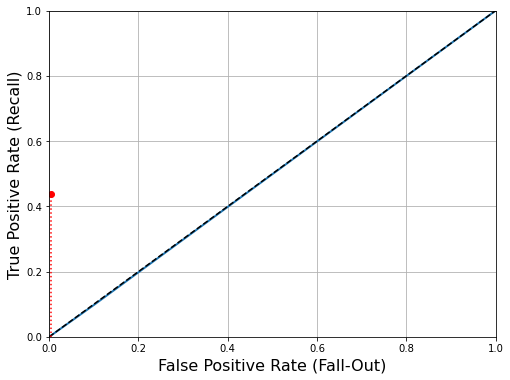

In [247]:
fpr, tpr, thresholds = roc_curve(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [248]:
roc_auc_score(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))

0.49874120604616196

In [249]:
test_preds_tweets = predict_tweet_text(Acc_info_model_tuned, test_data_acc, bert_embeddings_df_test, df_test)
test_preds_tweets.head()

,id,text,user.screen_name,user.id,suspended_label,pred
219,'1.2881540457486336e+18',@BatoolAamirian @AamirLiaquat @PTAofficialpk @...,ZainULA08298715,1.281064e+18,0,1.0
452,'1.3051962106183311e+18',#DeathPenaltyForRapistshttps://www.fiverr.com/...,Waqas77815985,1.285801e+18,0,1.0
212,'1.2858587652799488e+18',@daddycatesandy 我也希望喜歡我的人是因為喜歡我的個性，認同我的三觀而喜歡我。😊,lawrence19741,1.280864e+18,1,1.0
74,'1.2796344637611622e+18',@AWWk67D3QPyM6Ji 想抱,xixixix78789521,1.278926e+18,0,1.0
32,'1.2784498271232123e+18',#Kashmir \n#IndianArmy https://t.co/u60Cpmkyvs,AdnanBa23533546,1.278449e+18,0,1.0


In [250]:
test_preds_tweets.to_csv(results_bucket + 'account_level_results/full_test_interp/test_tweets_preds_acc_tuned.csv', index=False, encoding = "utf_8_sig")

Accounts

In [251]:
test_account_preds_acc_tuned = predict_account(Acc_info_model_tuned, test_data_acc, bert_embeddings_df_test, df_test)
test_account_preds_acc_tuned

,user.screen_name,suspended_label,total_pre_prob,mean_pred_prob,pred_class
461,tarrtarr012,0,1.995390e+02,4.555684e-01,1
63,CHauDHa66204206,0,1.519297e+02,9.995374e-01,1
173,Llong86182,0,1.315920e+02,5.721390e-01,1
290,UmairHa06689544,0,8.660984e+01,6.415544e-01,1
352,baig_tusif,0,7.982270e+01,9.977837e-01,1
294,UmarSha65660795,0,7.367691e+01,6.885692e-01,1
387,jimzhan04908044,0,5.980505e+01,5.025634e-01,1
138,Ishoo67840715,0,5.598328e+01,9.821628e-01,1
54,Azee84757895,1,4.599210e+01,4.741454e-01,1
321,Yongxian6606,0,4.336293e+01,9.636208e-01,1


In [252]:
test_account_preds_acc_tuned.to_csv(results_bucket + 'account_level_results/full_test_interp/test_account_preds_acc_tuned.csv', index=False, encoding = "utf_8_sig")

In [253]:
#report = classification_report(np.array(test_labels), predictions)
report_te_acc_tuned_tuned = classification_report(np.array(test_account_preds_acc_tuned['suspended_label']), np.array(test_account_preds_acc_tuned['pred_class']))
print(report_te_acc_tuned_tuned)

              precision    recall  f1-score   support

           0       0.94      0.75      0.83       460
           1       0.11      0.39      0.18        38

    accuracy                           0.72       498
   macro avg       0.53      0.57      0.50       498
weighted avg       0.87      0.72      0.78       498



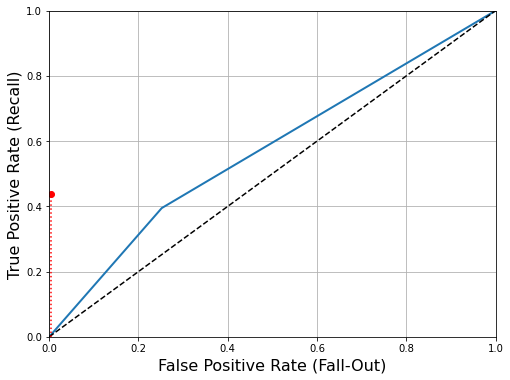

In [254]:
fpr, tpr, thresholds = roc_curve(np.array(test_account_preds_acc_tuned['suspended_label']), np.array(test_account_preds_acc_tuned['pred_class']))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [255]:
roc_auc_score(np.array(test_account_preds_acc_tuned['suspended_label']), np.array(test_account_preds_acc_tuned['pred_class']))

0.5712814645308926

#### Combined Model

Multilingual BERT

In [256]:
#gets shape of the data for the model
input_shape_combined=train_data[0].shape
input_shape_combined

(794,)

In [257]:
#Function to tune to the model
def tuner_builder(hp):
    inputs = keras.Input(shape=input_shape_combined, name="Tuned_Combined_Inputs") # They had 3333 (w CV) -> I hard coded my model shape. 
    x = layers.Dense(hp.Int('units', 50, 200, step = 20), activation="relu", name="dense_1")(inputs)
    x = layers.BatchNormalization(name="normalization_1")(x)
    x = layers.Dense(hp.Int('units1', 100, 200, step = 50), activation="relu",name="dense_2")(x)
    x = layers.Dense(hp.Int('units2', 20, 100, step = 20), activation=tf.keras.layers.LeakyReLU(alpha=0.2), name="dense_3")(x)
    x = layers.Dropout(hp.Float('dropout',0.0,0.50, step=0.10, default=0.10))(x)
    outputs = layers.Dense(2, activation="softmax",name="predictions")(x) # I get error now, but with full data there will be 2
    model = keras.Model(inputs=inputs, outputs=outputs, name="Tuned_Combined_Model")
    #Compile  model
    model.compile(optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

In [258]:
#tuner settings 
Combined_tuner = kt.Hyperband(
    tuner_builder,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory = 'Trial_run_combined3',
    project_name = 'Parameters_trials_combined_363636') # Need to be unique with each run!

In [259]:
#run through tuner
Combined_tuner.search(train_data, train_labels,validation_data=(valid_data, valid_labels),
             callbacks=[callback1,ClearTrainingOutput()])

Trial 90 Complete [00h 00m 26s]
val_accuracy: 0.8544638156890869

Best val_accuracy So Far: 0.8668941855430603
Total elapsed time: 00h 31m 54s
INFO:tensorflow:Oracle triggered exit


In [260]:
#gets best parameters
best_hyper_combined = Combined_tuner.get_best_hyperparameters(1)[0]
best_hyper_combined

In [261]:
print('Best Parameters for 1st Dense layer is', best_hyper_combined.get('units'))

Best Parameters for 1st Dense layer is 190


In [262]:
print('Best Parameters for 2nd Dense layer is', best_hyper_combined.get('units1'))

Best Parameters for 2nd Dense layer is 200


In [263]:
print('Best Parameters for 3rd Dense layer is', best_hyper_combined.get('units2'))

Best Parameters for 3rd Dense layer is 40


In [264]:
print('Best Parameters for Dropout layer is', best_hyper_combined.get('dropout'))

Best Parameters for Dropout layer is 0.5


In [265]:
print('Best learning rate for the ADAM is', best_hyper_combined.get('learning_rate'))

Best learning rate for the ADAM is 0.005008298972531056


In [266]:
#applies to tuning to model
Combined_model_tuned= Combined_tuner.hypermodel.build(best_hyper_combined)

In [267]:
#trials using newly tuned model
#Fitting on training and validation data based on selected tuning parameters
print("Fit model on training data with tuned model")
history_combined_tuned = Combined_model_tuned.fit(train_data, train_labels, epochs=2, batch_size=15,
                   validation_data=(valid_data, valid_labels), class_weight = class_weights)

Fit model on training data with tuned model
Epoch 1/2
5420/5420 [==============================] - 10s 2ms/step - loss: 0.9251 - accuracy: 0.8187 - val_loss: 0.5486 - val_accuracy: 0.8243
Epoch 2/2
5420/5420 [==============================] - 10s 2ms/step - loss: 0.7288 - accuracy: 0.8510 - val_loss: 0.7270 - val_accuracy: 0.7928


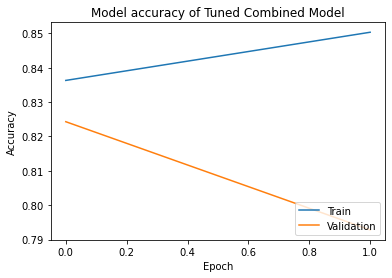

In [268]:
plot_combined_tuned=accuracy_plot('Model accuracy of Tuned Combined Model', history_combined_tuned)

In [269]:
# Evaluate the tuned model on the test data 
print("Evaluate tuned model on test data")
Combined_model_tuned_results = Combined_model_tuned.evaluate(test_data, test_labels, batch_size=10)

Evaluate tuned model on test data
2052/2052 [==============================] - 1s 661us/step - loss: 0.8370 - accuracy: 0.7683


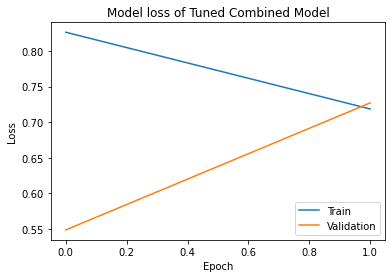

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [0.8370210528373718, 0.7682522535324097]


In [270]:
#train vs validation accuracy plot
plot_loss=loss_plot('Model loss of Tuned Combined Model', history_combined_tuned)
print(plot_loss)
#valid accuracy and loss 
print("test loss, test accuracy:", Combined_model_tuned_results)

#### Save Model 

In [271]:
from tensorflow.keras.layers import LeakyReLU
Combined_model_tuned.save('data/s3_data/model_output/full_test_interp_Combined_model_tuned.h5')  # creates a HDF5 file 'my_model.h5'

#### Import Model 

In [272]:
from tensorflow.keras.models import load_model
Combined_model_tuned = load_model('data/s3_data/model_output/full_test_interp_Combined_model_tuned.h5', custom_objects = {'LeakyReLU':LeakyReLU})

#### Predict

Tweets

In [273]:
#test predict_test
metrics_report_comb_tuned=predict_test(Combined_model_tuned,test_data,test_labels, fit_test)

# predicted_susp_tweettext
print(metrics_report_comb_tuned)

              precision    recall  f1-score   support

           0       0.90      0.84      0.87     18480
           1       0.08      0.13      0.10      2038

    accuracy                           0.77     20518
   macro avg       0.49      0.49      0.49     20518
weighted avg       0.82      0.77      0.79     20518



In [274]:
predictions = Combined_model_tuned.predict(test_data)

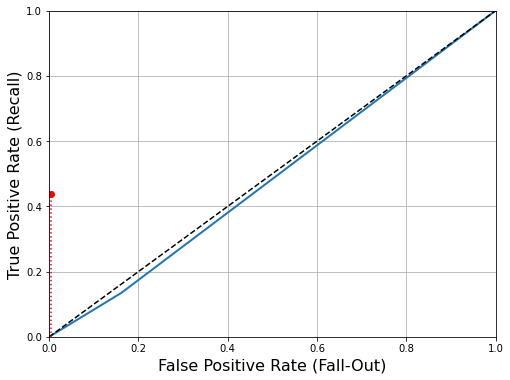

In [275]:
fpr, tpr, thresholds = roc_curve(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [276]:
roc_auc_score(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))

0.48651572503388013

In [277]:
test_preds_tweets = predict_tweet_text(Combined_model_tuned, test_data, bert_embeddings_df_test, df_test)
test_preds_tweets.head()

,id,text,user.screen_name,user.id,suspended_label,pred
371,'1.2905278435421676e+18',@jame_deane @zhanglifan 没读过书建议多读书再说话。,Lance15234488,1.283652e+18,0,0.999999
39,'1.2830064584943657e+18',@wifeycurtis @kpsharmaoli soon u'll become an...,ArnabD10,1.278560e+18,0,0.999997
74,'1.2796344637611622e+18',@AWWk67D3QPyM6Ji 想抱,xixixix78789521,1.278926e+18,0,0.999275
433,'1.2877905109421957e+18',@zhang_heqing 关注了,FhSYkK3LVq2bya9,1.285047e+18,1,0.996707
351,'1.2839495195461427e+18',@Fuuttaa 感觉给女鹅准备礼物她会很开心～,wincy38217042,1.283285e+18,0,0.996489


In [278]:
test_preds_tweets.to_csv(results_bucket + 'account_level_results/full_test_interp/test_tweets_preds_comb_tuned.csv', index=False, encoding = "utf_8_sig")

Accounts

In [279]:
test_account_preds_comb_tuned = predict_account(Combined_model_tuned, test_data, bert_embeddings_df_test, df_test)

In [280]:
test_account_preds_comb_tuned.to_csv(results_bucket + 'account_level_results/full_test_interp/test_account_preds_comb_tuned.csv', index=False, encoding = "utf_8_sig")

In [281]:
#report = classification_report(np.array(test_labels), predictions)
report_te_comb = classification_report(np.array(test_account_preds_comb_tuned['suspended_label']), np.array(test_account_preds_comb_tuned['pred_class']))
print(report_te_comb)

              precision    recall  f1-score   support

           0       0.92      0.43      0.58       460
           1       0.07      0.53      0.12        38

    accuracy                           0.44       498
   macro avg       0.49      0.48      0.35       498
weighted avg       0.85      0.44      0.55       498



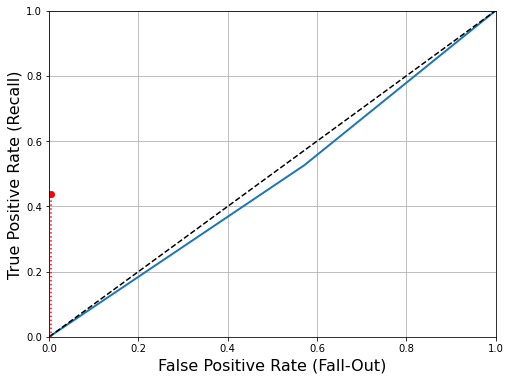

In [282]:
fpr, tpr, thresholds = roc_curve(np.array(test_account_preds_comb_tuned['suspended_label']), np.array(test_account_preds_comb_tuned['pred_class']))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [283]:
roc_auc_score(np.array(test_account_preds_comb_tuned['suspended_label']), np.array(test_account_preds_comb_tuned['pred_class']))

0.4772883295194507

Combined Model with LAbse

In [284]:
#gets shape of the data for the model
input_shape_combined_labse=train_data_labse[0].shape
input_shape_combined_labse

(794,)

In [285]:
#Function to tune to the model
def tuner_builder(hp):
    inputs = keras.Input(shape=input_shape_combined_labse, name="Tuned_Combined_Inputs") # They had 3333 (w CV) -> I hard coded my model shape. 
    x = layers.Dense(hp.Int('units', 50, 200, step = 20), activation="relu", name="dense_1")(inputs)
    x = layers.BatchNormalization(name="normalization_1")(x)
    x = layers.Dense(hp.Int('units1', 100, 200, step = 50), activation="relu",name="dense_2")(x)
    x = layers.Dense(hp.Int('units2', 20, 100, step = 20), activation=tf.keras.layers.LeakyReLU(alpha=0.2), name="dense_3")(x)
    x = layers.Dropout(hp.Float('dropout',0.0,0.50, step=0.10, default=0.10))(x)
    outputs = layers.Dense(2, activation="softmax",name="predictions")(x) # I get error now, but with full data there will be 2
    model = keras.Model(inputs=inputs, outputs=outputs, name="Tuned_Combined_Model")
    #Compile  model
    model.compile(optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

In [286]:
#tuner settings 
Combined_tuner = kt.Hyperband(
    tuner_builder,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory = 'Trial_run_combined2',
    project_name = 'Parameters_trials_combined_labse_818181') # Need to be unique with each run!

In [287]:
#run through tuner
Combined_tuner.search(train_data_labse, train_labels_labse,validation_data=(valid_data_labse, valid_labels_labse),
             callbacks=[callback1,ClearTrainingOutput()])

Trial 90 Complete [00h 00m 21s]
val_accuracy: 0.8593497276306152

Best val_accuracy So Far: 0.8760553002357483
Total elapsed time: 00h 25m 29s
INFO:tensorflow:Oracle triggered exit


In [288]:
#gets best parameters
best_hyper_combined_labse = Combined_tuner.get_best_hyperparameters(1)[0]
best_hyper_combined_labse

In [289]:
print('Best Parameters for 1st Dense layer is', best_hyper_combined_labse.get('units'))

Best Parameters for 1st Dense layer is 190


In [290]:
print('Best Parameters for 2nd Dense layer is', best_hyper_combined_labse.get('units1'))

Best Parameters for 2nd Dense layer is 150


In [291]:
print('Best Parameters for 3rd Dense layer is', best_hyper_combined_labse.get('units2'))

Best Parameters for 3rd Dense layer is 80


In [292]:
print('Best Parameters for Dropout layer is', best_hyper_combined_labse.get('dropout'))

Best Parameters for Dropout layer is 0.0


In [293]:
print('Best learning rate for the ADAM is', best_hyper_combined_labse.get('learning_rate'))

Best learning rate for the ADAM is 0.007402925076656829


In [294]:
#applies to tuning to model
Combined_model_tuned_labse= Combined_tuner.hypermodel.build(best_hyper_combined_labse)

In [295]:
#trials using newly tuned model
#Fitting on training and validation data based on selected tuning parameters
print("Fit model on training data with tuned model")
history_combined_tuned_labse = Combined_model_tuned_labse.fit(train_data_labse, train_labels_labse, epochs=2, batch_size=15,
                   validation_data=(valid_data_labse, valid_labels_labse), class_weight = class_weights_labse)

Fit model on training data with tuned model
Epoch 1/2
5420/5420 [==============================] - 9s 2ms/step - loss: 0.6794 - accuracy: 0.8590 - val_loss: 0.5344 - val_accuracy: 0.8364
Epoch 2/2
5420/5420 [==============================] - 9s 2ms/step - loss: 0.4536 - accuracy: 0.9191 - val_loss: 0.7240 - val_accuracy: 0.7860


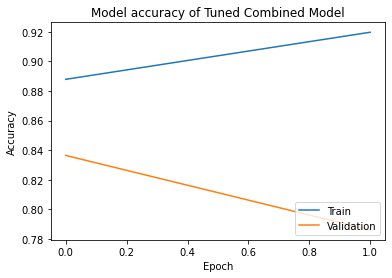

In [296]:
plot_combined_tuned_labse=accuracy_plot('Model accuracy of Tuned Combined Model', history_combined_tuned_labse)

In [297]:
# Evaluate the tuned model on the test data 
print("Evaluate tuned model on test data")
Combined_model_tuned_results_labse = Combined_model_tuned_labse.evaluate(test_data_labse, test_labels_labse, batch_size=10)

Evaluate tuned model on test data
2052/2052 [==============================] - 1s 654us/step - loss: 1.1568 - accuracy: 0.7919


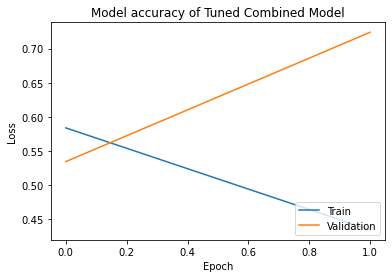

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [1.1568448543548584, 0.791890025138855]


In [298]:
#train vs validation accuracy plot
plot_loss=loss_plot('Model accuracy of Tuned Combined Model', history_combined_tuned_labse)
print(plot_loss)
#valid accuracy and loss 
print("test loss, test accuracy:", Combined_model_tuned_results_labse)

In [299]:
from tensorflow.keras.layers import LeakyReLU
Combined_model_tuned_labse.save('data/s3_data/model_output/full_test_interp_Combined_model_tuned_labse.h5')  # creates a HDF5 file 'my_model.h5'

In [300]:
from tensorflow.keras.models import load_model
Combined_model_tuned_labse= load_model('data/s3_data/model_output/full_test_interp_Combined_model_tuned_labse.h5', custom_objects = {'LeakyReLU':LeakyReLU})

In [301]:
#test predict_test
metrics_report_comb_tuned_labse=predict_test(Combined_model_tuned_labse,test_data_labse,test_labels_labse, fit_test_labse)

# predicted_susp_tweettext
print(metrics_report_comb_tuned_labse)

              precision    recall  f1-score   support

           0       0.90      0.87      0.88     18480
           1       0.09      0.12      0.10      2038

    accuracy                           0.79     20518
   macro avg       0.49      0.49      0.49     20518
weighted avg       0.82      0.79      0.80     20518



In [302]:
predictions = Combined_model_tuned_labse.predict(test_data_labse)

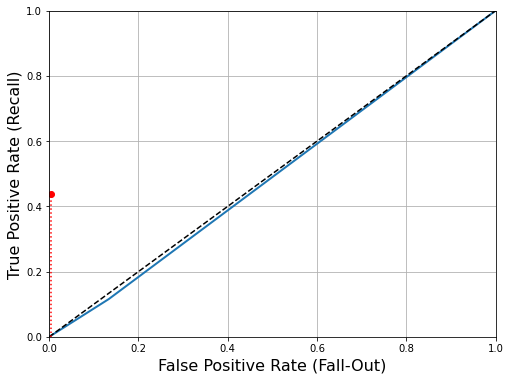

In [303]:
fpr, tpr, thresholds = roc_curve(np.argmax(test_labels_labse, axis=1), np.argmax(predictions, axis=1))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [304]:
roc_auc_score(np.argmax(test_labels_labse, axis=1), np.argmax(predictions, axis=1))

0.4911250100896814

In [305]:
test_preds_tweets = predict_tweet_text(Combined_model_tuned_labse, test_data_labse, bert_embeddings_df_test_labse, df_test)
test_preds_tweets.head()

,id,text,user.screen_name,user.id,suspended_label,pred
449,'1.2880096353796096e+18',@Vikashk62800388 @CGTNOfficial 恶心🙂,shanheyonggu2,1.285622e+18,0,0.999988
452,'1.3051962106183311e+18',#DeathPenaltyForRapistshttps://www.fiverr.com/...,Waqas77815985,1.285801e+18,0,0.999923
74,'1.2796344637611622e+18',@AWWk67D3QPyM6Ji 想抱,xixixix78789521,1.278926e+18,0,0.999881
89,'1.280216436473041e+18',@realDonaldTrump You're really a shirker！,WvU46oIgqdh88d0,1.279099e+18,0,0.999781
201,'1.2812576462308147e+18',@TonySta96226313 Mane pahly bi kaya tha per os...,abuzar_malik206,1.280674e+18,0,0.999659


In [306]:
test_preds_tweets.to_csv(results_bucket + 'account_level_results/full_test_interp/test_tweets_preds_comb_tuned_labse.csv', index=False, encoding = "utf_8_sig")

Test

In [307]:
test_account_preds_comb_tuned_labse = predict_account(Combined_model_tuned_labse, test_data_labse, bert_embeddings_df_test_labse, df_test)

In [308]:
test_account_preds_comb_tuned_labse.to_csv(results_bucket + 'account_level_results/full_test_interp/test_account_preds_comb_tuned_labse.csv', index=False, encoding = "utf_8_sig")

In [309]:
#report = classification_report(np.array(test_labels), predictions)
report_te_comb_labse = classification_report(np.array(test_account_preds_comb_tuned_labse['suspended_label']), np.array(test_account_preds_comb_tuned_labse['pred_class']))
print(report_te_comb_labse)

              precision    recall  f1-score   support

           0       0.94      0.57      0.70       460
           1       0.09      0.53      0.16        38

    accuracy                           0.56       498
   macro avg       0.51      0.55      0.43       498
weighted avg       0.87      0.56      0.66       498



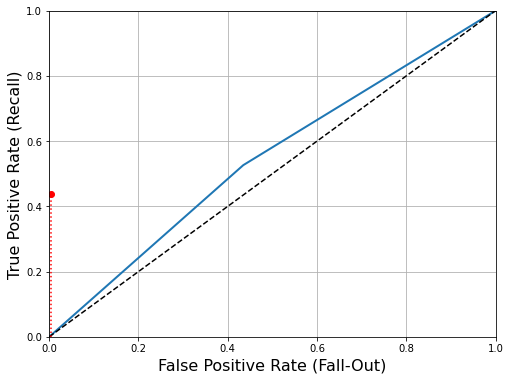

In [310]:
fpr, tpr, thresholds = roc_curve(np.array(test_account_preds_comb_tuned_labse['suspended_label']), np.array(test_account_preds_comb_tuned_labse['pred_class']))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [311]:
roc_auc_score(np.array(test_account_preds_comb_tuned_labse['suspended_label']), np.array(test_account_preds_comb_tuned_labse['pred_class']))

0.545766590389016